In [1]:
import numpy as np
class Node:#定义神经网络节点
    def __init__(self,inputs=[]):
        self.inputs = inputs
        self.outputs=[]
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None
        self.value=None
        self.gradients={} #梯度    
    def forward(self):#前向传播，继承该类的类会覆写该函数
        raise NotImplemented #触发异常：未实现
    def backward(self):#反向传播
        raise NotImplemented

In [2]:
class Input(Node):#Node的子类
    def __init__(self):
        Node.__init__(self)
    def forward(self, value=None):
        if value is not None:
            self.value=value
    def backward(self):
        self.gradients = {self:0}#梯度初始化
        for n in self.outputs:
            grad_cost = n.gradients[self]#输出节点对该节点的梯度
            self.gradients[self] = grad_cost*1#前面的点为常量，梯度为1
       

In [3]:
class Add(Node):
    def __init__(self,*nodes):
        Node.__init__(self,nodes)
    def forward(self):#按设计的函数进行映射
        self.value = sum(map(lambda n: n.value, self.inputs))

In [4]:
class Linear(Node):#全连接网络层的计算
    def __init__(self,nodes,weights,bias):
        Node.__init__(self,[nodes, weights, bias])
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value#权重
        bias = self.inputs[2].value#误差
        self.value = np.dot(inputs,weights)+bias#y=wTx+b
    def backward(self):
        self.gradients={n:np.zeros_like(n.value) for n in self.inputs}
        #初始化输入
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]]=np.dot(grad_cost,self.inputs[1].value.T)
            # x的梯度为w 
            self.gradients[self.inputs[1]]=np.dot(self.inputs[0].value.T,grad_cost)
            # w的梯度为x
            self.gradients[self.inputs[2]]=np.sum(grad_cost,axis=0,keepdims=False)
            # bias的梯度为1，axis=0,在第一个轴上展开求和；keepdims=False保持矩阵二维特性。

# Sigmoid函数

In [5]:
class Sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self,[node])
    def _sigmoid(self,x):
        return 1./(1+np.exp(-1*x))#Sigmoid函数表达式
    def forward(self):
        self.x = self.inputs[0].value
        self.value =self._sigmoid(self.x)
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1-self._sigmoid(self.x))
        #计算Sigmoid函数梯度表达式
        self.gradients = {n:np.zeros_like(n.value) for n in self.inputs}
        #初始化，数组n.value所有元素设置为0
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]]=grad_cost * self.partial
        

# 均方误差

In [6]:
class MSE(Node):
    def __init__(self,y,a):
        Node.__init__(self,[y,a])
    def forward(self):
        y=self.inputs[0].value.reshape(-1,1)
        a=self.inputs[1].value.reshape(-1,1)
        assert(y.shape == a.shape)#断言 过多assert是False则终止
        self.m= self.inputs[0].value.shape[0]
        self.diff = y -a
        self.value = np.mean(self.diff**2)
    def backward(self):
        self.gradients[self.inputs[0]]=(2/self.m) *self.diff
        self.gradients[self.inputs[1]]=(-2/self.m) * self.diff
        

In [7]:
def forward_and_backward(outputnode,graph):
    for n in graph:
        n.forward()
    for n in graph[::-1]:#d倒叙
        n.backward()

# 拓扑排序

In [8]:
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)#截取第一个节点n
        if n not in G:
            G[n] = {'in':set(),'out':set()}#用set()集合表示输入输出
        for m in n.outputs:#n的下一个节点是m
            if m not in G:
                G[m] = {'in':set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L= []
    S = set(input_nodes)
    while len(S)>0:
        n=S.pop()
        if isinstance(n,Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) ==0:#如果没有其他传入S
                S.add(m)
    return L



# 随机梯度下降 

In [9]:
def sgd_update(trainables,learning_rate=1e-2):
    for t in trainables:
        t.value += -1*learning_rate * t.gradients[t]#-1*学习率*梯度

# 波士顿房价案例

In [23]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle,resample
X_ = data['data']
y_ = data['target']
X_ = (X_ - np.mean(X_,axis=0)) / np.std(X_,axis=0)
#标准化数据，二维数组中axis=0是纵向，axis=1是横向
n_features = X_.shape[1]#返回矩阵X_[1] 长度：13
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
#创建一个二维数组，包含13个子数组，每个子数组中有10个元素
b1_ = np.zeros(n_hidden)#[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)#[0.]

#设置两层的神经网络
X,y = Input(), Input()#节点
W1,b1 = Input(), Input()
W2,b2 = Input(), Input()

l1 = Linear(X, W1, b1)#第一个接收层
s1 = Sigmoid(l1)
l2 = Linear(s1 ,W2, b2)#神经网络的输出/预测值
cost = MSE(y, l2)# (预测值l2-真实值y)^2

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
m = X_.shape[0] #506,数组X_的长度
batch_size = 16
steps_per_epoch = m // batch_size
graph = topological_sort(feed_dict)#进行拓扑排序
trainables = [W1, b1, W2, b2]#可训练参数
print("Total number of example = {}".format(m))
  

[2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
 7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
 9.1400e+00]
Total number of example = 506


In [11]:
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch= resample(X_, y_, n_samples=batch_size)
        #重新采样，随机生成，每个列表16个元素
        X.value = X_batch
        y.value = y_batch   
        _= None
        forward_and_backward(_, graph)
        rate = 1e-2
        sgd_update(trainables, rate)       
        loss += graph[-1].value
    if i%100 ==0:#每100次迭代输出一次结果
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)  

Epoch: 1, Loss: 214.535
Epoch: 101, Loss: 6.282
Epoch: 201, Loss: 5.908
Epoch: 301, Loss: 4.003
Epoch: 401, Loss: 3.564
Epoch: 501, Loss: 3.901
Epoch: 601, Loss: 3.148
Epoch: 701, Loss: 3.290
Epoch: 801, Loss: 3.448
Epoch: 901, Loss: 2.940
Epoch: 1001, Loss: 2.863
Epoch: 1101, Loss: 3.365
Epoch: 1201, Loss: 3.151
Epoch: 1301, Loss: 2.682
Epoch: 1401, Loss: 3.124
Epoch: 1501, Loss: 2.874
Epoch: 1601, Loss: 3.169
Epoch: 1701, Loss: 2.931
Epoch: 1801, Loss: 3.392
Epoch: 1901, Loss: 3.365
Epoch: 2001, Loss: 2.690
Epoch: 2101, Loss: 2.912
Epoch: 2201, Loss: 3.329
Epoch: 2301, Loss: 3.163
Epoch: 2401, Loss: 3.068
Epoch: 2501, Loss: 2.970
Epoch: 2601, Loss: 3.063
Epoch: 2701, Loss: 3.029
Epoch: 2801, Loss: 3.554
Epoch: 2901, Loss: 3.080
Epoch: 3001, Loss: 2.665
Epoch: 3101, Loss: 3.138
Epoch: 3201, Loss: 3.315
Epoch: 3301, Loss: 3.026
Epoch: 3401, Loss: 3.051
Epoch: 3501, Loss: 2.914
Epoch: 3601, Loss: 3.055
Epoch: 3701, Loss: 2.886
Epoch: 3801, Loss: 2.906
Epoch: 3901, Loss: 2.874
Epoch: 400

In [12]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value
forward(l2,graph)

array([[23.64091995],
       [15.43756488],
       [21.20109877],
       [17.36962266],
       [17.39768834],
       [16.53284509],
       [21.46236589],
       [27.85395839],
       [17.55335967],
       [19.85114598],
       [ 9.15642647],
       [21.92981681],
       [18.52423615],
       [14.4058499 ],
       [33.53996814],
       [33.17437882]])

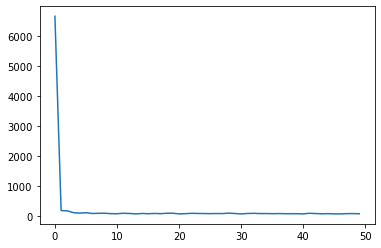

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses)

In [14]:
W2.value

array([[ 5.735171  ],
       [13.67862215],
       [11.03653431],
       [ 5.97101661],
       [12.50251048],
       [ 5.48714209],
       [-5.05969972],
       [ 6.70748384],
       [11.84333596],
       [-6.51784056]])

In [15]:
X_ = data['data']
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [16]:
import keras
X_[0]

Using TensorFlow backend.


array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [17]:
from keras.layers import Dense
from keras.models import Sequential
model = Sequential()
model.add(Dense(units=64,activation='sigmoid',input_dim=13))
model.add(Dense(units=30,activation='sigmoid',input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])


In [ ]:
model.fit(X_, y_, epochs=5000,batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 364us/step - loss: 152.7699 - mse: 152.7699
Epoch 2/5000
506/506 [==============================] - 0s 67us/step - loss: 79.1528 - mse: 79.1528
Epoch 3/5000
506/506 [==============================] - 0s 91us/step - loss: 78.2766 - mse: 78.2766
Epoch 4/5000
506/506 [==============================] - 0s 77us/step - loss: 78.6555 - mse: 78.6555
Epoch 5/5000
506/506 [==============================] - 0s 79us/step - loss: 83.3595 - mse: 83.3595
Epoch 6/5000
506/506 [==============================] - 0s 77us/step - loss: 85.7549 - mse: 85.7549
Epoch 7/5000
506/506 [==============================] - 0s 71us/step - loss: 82.9274 - mse: 82.9274
Epoch 8/5000
506/506 [==============================] - 0s 65us/step - loss: 81.6535 - mse: 81.6535
Epoch 9/5000
506/506 [==============================] - 0s 65us/step - loss: 80.7551 - mse: 80.7551
Epoch 10/5000
506/506 [==============================] - 0s 83us/step - loss: 83.3703 - mse: 83.3

506/506 [==============================] - 0s 99us/step - loss: 77.5426 - mse: 77.5426
Epoch 162/5000
506/506 [==============================] - 0s 97us/step - loss: 78.1654 - mse: 78.1654
Epoch 163/5000
506/506 [==============================] - 0s 81us/step - loss: 78.1042 - mse: 78.1042
Epoch 164/5000
506/506 [==============================] - 0s 97us/step - loss: 79.0880 - mse: 79.0880
Epoch 165/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5657 - mse: 77.5657
Epoch 166/5000
506/506 [==============================] - 0s 63us/step - loss: 77.3305 - mse: 77.3305
Epoch 167/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7502 - mse: 77.7502
Epoch 168/5000
506/506 [==============================] - 0s 55us/step - loss: 77.8464 - mse: 77.8464
Epoch 169/5000
506/506 [==============================] - 0s 75us/step - loss: 77.7820 - mse: 77.7820
Epoch 170/5000
506/506 [==============================] - 0s 71us/step - loss: 77.9682 - mse: 77.

506/506 [==============================] - 0s 73us/step - loss: 77.4746 - mse: 77.4746
Epoch 322/5000
506/506 [==============================] - 0s 69us/step - loss: 77.1519 - mse: 77.1518
Epoch 323/5000
506/506 [==============================] - 0s 83us/step - loss: 77.8465 - mse: 77.8465
Epoch 324/5000
506/506 [==============================] - 0s 59us/step - loss: 77.2024 - mse: 77.2024
Epoch 325/5000
506/506 [==============================] - 0s 81us/step - loss: 77.7580 - mse: 77.7580
Epoch 326/5000
506/506 [==============================] - 0s 89us/step - loss: 77.4678 - mse: 77.4678
Epoch 327/5000
506/506 [==============================] - 0s 77us/step - loss: 77.4529 - mse: 77.4529
Epoch 328/5000
506/506 [==============================] - 0s 87us/step - loss: 78.1744 - mse: 78.1744
Epoch 329/5000
506/506 [==============================] - 0s 69us/step - loss: 77.1271 - mse: 77.1271
Epoch 330/5000
506/506 [==============================] - 0s 85us/step - loss: 77.2263 - mse: 77.

506/506 [==============================] - 0s 87us/step - loss: 77.2736 - mse: 77.2736
Epoch 402/5000
506/506 [==============================] - 0s 79us/step - loss: 77.4533 - mse: 77.4533
Epoch 403/5000
506/506 [==============================] - 0s 113us/step - loss: 77.5439 - mse: 77.5439
Epoch 404/5000
506/506 [==============================] - 0s 97us/step - loss: 77.1185 - mse: 77.1185
Epoch 405/5000
506/506 [==============================] - 0s 89us/step - loss: 77.3244 - mse: 77.3244
Epoch 406/5000
506/506 [==============================] - 0s 59us/step - loss: 77.1122 - mse: 77.1122
Epoch 407/5000
506/506 [==============================] - 0s 79us/step - loss: 77.3046 - mse: 77.3046
Epoch 408/5000
506/506 [==============================] - 0s 87us/step - loss: 77.7204 - mse: 77.7204
Epoch 409/5000
506/506 [==============================] - 0s 53us/step - loss: 77.0991 - mse: 77.0991
Epoch 410/5000
506/506 [==============================] - 0s 61us/step - loss: 77.2371 - mse: 77

506/506 [==============================] - 0s 47us/step - loss: 77.0254 - mse: 77.0254
Epoch 482/5000
506/506 [==============================] - 0s 43us/step - loss: 77.5568 - mse: 77.5568
Epoch 483/5000
506/506 [==============================] - 0s 45us/step - loss: 77.2734 - mse: 77.2734
Epoch 484/5000
506/506 [==============================] - 0s 57us/step - loss: 77.2463 - mse: 77.2463
Epoch 485/5000
506/506 [==============================] - 0s 43us/step - loss: 77.7882 - mse: 77.7882
Epoch 486/5000
506/506 [==============================] - 0s 43us/step - loss: 77.3042 - mse: 77.3042
Epoch 487/5000
506/506 [==============================] - 0s 42us/step - loss: 77.6791 - mse: 77.6791
Epoch 488/5000
506/506 [==============================] - 0s 53us/step - loss: 77.1934 - mse: 77.1934
Epoch 489/5000
506/506 [==============================] - 0s 47us/step - loss: 77.6208 - mse: 77.6208
Epoch 490/5000
506/506 [==============================] - 0s 49us/step - loss: 78.0935 - mse: 78.

506/506 [==============================] - 0s 53us/step - loss: 77.4417 - mse: 77.4417
Epoch 642/5000
506/506 [==============================] - 0s 73us/step - loss: 77.5661 - mse: 77.5661
Epoch 643/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5227 - mse: 77.5227
Epoch 644/5000
506/506 [==============================] - 0s 51us/step - loss: 77.4351 - mse: 77.4351
Epoch 645/5000
506/506 [==============================] - 0s 53us/step - loss: 77.4613 - mse: 77.4613
Epoch 646/5000
506/506 [==============================] - 0s 51us/step - loss: 77.2380 - mse: 77.2380
Epoch 647/5000
506/506 [==============================] - 0s 51us/step - loss: 77.4920 - mse: 77.4920
Epoch 648/5000
506/506 [==============================] - 0s 113us/step - loss: 77.5810 - mse: 77.5810
Epoch 649/5000
506/506 [==============================] - 0s 71us/step - loss: 77.6055 - mse: 77.6055
Epoch 650/5000
506/506 [==============================] - 0s 103us/step - loss: 77.3165 - mse: 7

506/506 [==============================] - 0s 59us/step - loss: 77.2483 - mse: 77.2483
Epoch 722/5000
506/506 [==============================] - 0s 73us/step - loss: 77.4763 - mse: 77.4763
Epoch 723/5000
506/506 [==============================] - 0s 87us/step - loss: 77.4650 - mse: 77.4650
Epoch 724/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6203 - mse: 77.6203
Epoch 725/5000
506/506 [==============================] - 0s 79us/step - loss: 77.6806 - mse: 77.6806
Epoch 726/5000
506/506 [==============================] - 0s 53us/step - loss: 78.0629 - mse: 78.0629
Epoch 727/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4126 - mse: 77.4126
Epoch 728/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7841 - mse: 77.7841
Epoch 729/5000
506/506 [==============================] - 0s 65us/step - loss: 78.2613 - mse: 78.2613
Epoch 730/5000
506/506 [==============================] - 0s 63us/step - loss: 78.5231 - mse: 78.